In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("Populations.csv")
columns = ["Region, subregion, country or area *", "Year", "Type",  "Parent code",
    "Total Population, as of 1 January (thousands)",
    "Total Population, as of 1 July (thousands)",
    "Male Population, as of 1 July (thousands)",
    "Female Population, as of 1 July (thousands)",
    "Population Density, as of 1 July (persons per square km)",
    "Population Sex Ratio, as of 1 July (males per 100 females)",
    "Median Age, as of 1 July (years)",
    "Natural Change, Births minus Deaths (thousands)",
    "Rate of Natural Change (per 1,000 population)",
    "Population Change (thousands)",
    "Population Growth Rate (percentage)",
    "Births (thousands)",
    "Births by women aged 15 to 19 (thousands)",
    "Crude Birth Rate (births per 1,000 population)",
    "Total Fertility Rate (live births per woman)",
    "Net Reproduction Rate (surviving daughters per woman)",
    "Mean Age Childbearing (years)",
    "Sex Ratio at Birth (males per 100 female births)",
    "Total Deaths (thousands)",
    "Male Deaths (thousands)",
    "Female Deaths (thousands)",
    "Crude Death Rate (deaths per 1,000 population)",
    "Life Expectancy at Birth, both sexes (years)",
    "Male Life Expectancy at Birth (years)",
    "Female Life Expectancy at Birth (years)",
    "Life Expectancy at Age 15, both sexes (years)",
    "Male Life Expectancy at Age 15 (years)",
    "Female Life Expectancy at Age 15 (years)",
    "Life Expectancy at Age 65, both sexes (years)",
    "Male Life Expectancy at Age 65 (years)",
    "Female Life Expectancy at Age 65 (years)",
    "Life Expectancy at Age 80, both sexes (years)",
    "Male Life Expectancy at Age 80 (years)",
    "Female Life Expectancy at Age 80 (years)",
    "Infant Deaths, under age 1 (thousands)",
    "Infant Mortality Rate (infant deaths per 1,000 live births)",
    "Live Births Surviving to Age 1 (thousands)",
    "Under-Five Deaths, under age 5 (thousands)",
    "Under-Five Mortality (deaths under age 5 per 1,000 live births)",
    "Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)",
    "Male Mortality before Age 40 (deaths under age 40 per 1,000 male live births)",
    "Female Mortality before Age 40 (deaths under age 40 per 1,000 female live births)",
    "Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)",
    "Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)",
    "Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)",
    "Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)",
    "Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)",
    "Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)",
    "Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)",
    "Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)",
    "Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",
    "Net Number of Migrants (thousands)",
    "Net Migration Rate (per 1,000 population)"
]

data = data[columns]
heatmap_data = data
world_data = data[ data["Type"] == "World"]
region_data = data[data["Type"] == "SDG region"]
data = data[data["Type"] == "Country/Area"]

data = data.dropna()

C:\Users\justi\AppData\Local\Temp\ipykernel_32128\2701659443.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Populations.csv")


In [65]:
# numerical_columns = [
#     "Year", "Total Population, as of 1 January (thousands)", 
#     "Total Population, as of 1 July (thousands)", "Male Population, as of 1 July (thousands)", 
#     "Female Population, as of 1 July (thousands)", "Median Age, as of 1 July (years)", 
#     "Population Change (thousands)", "Births (thousands)", 
#     "Total Fertility Rate (live births per woman)", 
#     "Population Density, as of 1 July (persons per square km)", 
#     "Under-Five Mortality (deaths under age 5 per 1,000 live births)", 
#     "Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)", 
#     "Net Number of Migrants (thousands)", 
#     "Live Births Surviving to Age 1 (thousands)", 
#     "Life Expectancy at Age 80, both sexes (years)", 
#     "Total Deaths (thousands)", 
#     "Life Expectancy at Birth, both sexes (years)", 
#     "Sex Ratio at Birth (males per 100 female births)", 
#     "Net Reproduction Rate (surviving daughters per woman)", 
#     "Rate of Natural Change (per 1,000 population)", 
#     "Population Growth Rate (percentage)", 
#     "Births by women aged 15 to 19 (thousands)", 
#     "Crude Birth Rate (births per 1,000 population)"
# ]

# numerical_data = data[numerical_columns]

# # Standardize the numerical data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(numerical_data)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# tsne_results = tsne.fit_transform(numerical_data)

# # Visualize the results
# plt.figure(figsize=(10, 6))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)
# plt.title("t-SNE Visualization of Population Data")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.show()

In [ ]:
depths = [50, 100, 200, 500]
n_estimators = [10, 50, 100, 200, 500]
max_features = ["sqrt", "log2", None]
y = data["Total Population, as of 1 January (thousands)"]
X = data.drop(["Parent code", "Region, subregion, country or area *", "Type","Total Population, as of 1 January (thousands)", "Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)", "Female Population, as of 1 July (thousands)"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=476)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X, y, test_size=0.125, random_state=476)

for depth in depths:
    for estimators in n_estimators:
        for features in max_features:
            clf = RandomForestRegressor(criterion='squared_error', n_estimators=estimators, n_jobs=-1, max_depth=depth)
            clf.fit(X_subtrain, y_subtrain)
            y_predict = clf.predict(X_val)
            print(depth, estimators, features, root_mean_squared_error(y_val,y_predict))

50 10 sqrt 6991.257989465905
50 10 log2 8512.264780097343
50 10 None 7515.195386400199
50 50 sqrt 7353.5944551593875
50 50 log2 7388.571243051791
50 50 None 7554.970738229773
50 100 sqrt 7857.421178453141
50 100 log2 7676.087428584102
50 100 None 7697.3275705272445
50 200 sqrt 7926.097999158462


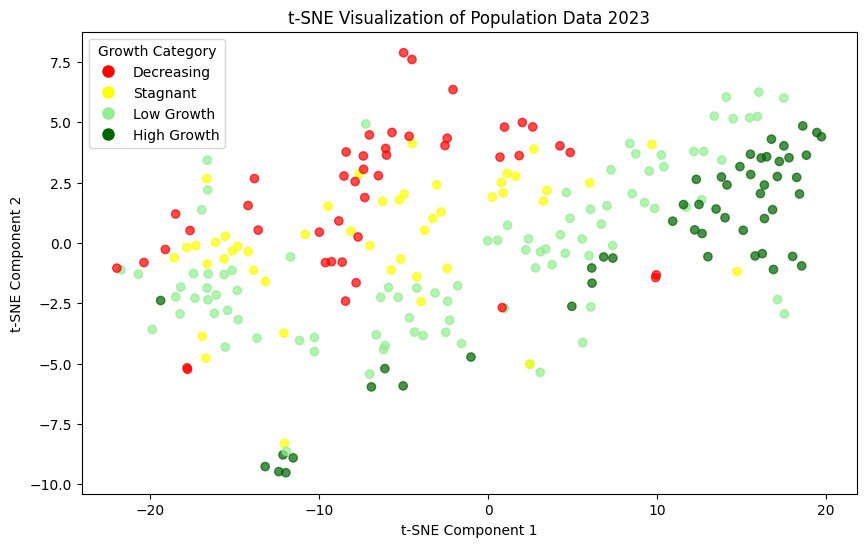

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Assuming 'X' is your DataFrame
# Categorize based on 'Population Growth Rate (percentage)'
def categorize_growth_rate(row):
    growth_rate = row['Population Growth Rate (percentage)']
    if growth_rate > 2:
        return 'High Growth'
    elif 0.5 < growth_rate <= 2:
        return 'Low Growth'
    elif -0.2 <= growth_rate <= 0.5:
        return 'Stagnant'
    else:
        return 'Decreasing'

# Filter the DataFrame for the year 2023
X_subtrain = X[X['Year'] == 2023].copy()

# Apply the categorization function
X_subtrain['Growth Category'] = X_subtrain.apply(categorize_growth_rate, axis=1)

# Define the numerical columns
numerical_columns = [
    "Population Density, as of 1 July (persons per square km)",
    "Population Sex Ratio, as of 1 July (males per 100 females)",
    "Median Age, as of 1 July (years)",
    "Natural Change, Births minus Deaths (thousands)",
    "Rate of Natural Change (per 1,000 population)",
    "Population Change (thousands)",
    "Population Growth Rate (percentage)",
    "Births (thousands)",
    "Births by women aged 15 to 19 (thousands)",
    "Crude Birth Rate (births per 1,000 population)",
    "Total Fertility Rate (live births per woman)",
    "Net Reproduction Rate (surviving daughters per woman)",
    "Mean Age Childbearing (years)",
    "Sex Ratio at Birth (males per 100 female births)",
    "Total Deaths (thousands)",
    "Male Deaths (thousands)",
    "Female Deaths (thousands)",
    "Crude Death Rate (deaths per 1,000 population)",
    "Life Expectancy at Birth, both sexes (years)",
    "Male Life Expectancy at Birth (years)",
    "Female Life Expectancy at Birth (years)",
    "Life Expectancy at Age 15, both sexes (years)",
    "Male Life Expectancy at Age 15 (years)",
    "Female Life Expectancy at Age 15 (years)",
    "Life Expectancy at Age 65, both sexes (years)",
    "Male Life Expectancy at Age 65 (years)",
    "Female Life Expectancy at Age 65 (years)",
    "Life Expectancy at Age 80, both sexes (years)",
    "Male Life Expectancy at Age 80 (years)",
    "Female Life Expectancy at Age 80 (years)",
    "Infant Deaths, under age 1 (thousands)",
    "Infant Mortality Rate (infant deaths per 1,000 live births)",
    "Live Births Surviving to Age 1 (thousands)",
    "Under-Five Deaths, under age 5 (thousands)",
    "Under-Five Mortality (deaths under age 5 per 1,000 live births)",
    "Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)",
    "Male Mortality before Age 40 (deaths under age 40 per 1,000 male live births)",
    "Female Mortality before Age 40 (deaths under age 40 per 1,000 female live births)",
    "Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)",
    "Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)",
    "Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)",
    "Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)",
    "Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)",
    "Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)",
    "Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)",
    "Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)",
    "Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",
    "Net Number of Migrants (thousands)",
    "Net Migration Rate (per 1,000 population)"
]

# Extract the numerical data
numerical_data = X_subtrain[numerical_columns]

# Standardize the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Add the t-SNE results to the DataFrame
X_subtrain.loc[:, 'tsne-2d-one'] = tsne_results[:, 0]
X_subtrain.loc[:, 'tsne-2d-two'] = tsne_results[:, 1]

# Define the color map
category_colors = {
    'Decreasing': 'red',
    'Stagnant': 'yellow',
    'Low Growth': 'lightgreen',
    'High Growth': 'darkgreen'
}

# Map the colors to the growth categories
colors = X_subtrain['Growth Category'].map(category_colors)

# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_subtrain['tsne-2d-one'], X_subtrain['tsne-2d-two'], 
    c=colors, alpha=0.7
)
# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in category_colors.values()]
labels = category_colors.keys()
plt.legend(handles, labels, title="Growth Category")

plt.title("t-SNE Visualization of Population Data 2023")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
